# Setup

In [10]:
!pip install patchify

In [11]:
import numpy as np
from matplotlib import pyplot as plt

# Dataset Preprocessing

In [ ]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

# root_directory = 'facades-dataset/'
root_directory = '/content/labelmefacade'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then
#divide all images into patches of 256x256x3.

image_dataset = []

count = 0
max_count = 500

for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images...

                if count == max_count:
                    break
                else:
                    count += 1
                image = cv2.imread(f"{path}/{image_name}", 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                # image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", f"{path}/{image_name}")
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)



count = 0
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'labels':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)

                if count == max_count:
                    break
                else:
                    count += 1

                mask = cv2.imread(f"{path}/{mask_name}", 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                # mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                print("Now patchifying mask:", f"{path}/{mask_name}")
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
image_dataset.shape, mask_dataset.shape

((2008, 256, 256, 3), (2008, 256, 256, 3))

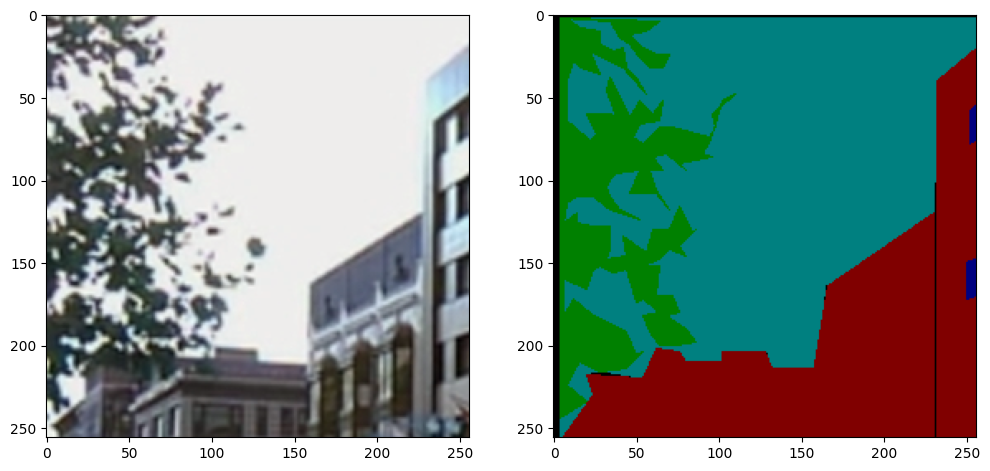

In [ ]:
import random

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [ ]:
# Define RGB values for each class
class_colors = {
    (0, 0, 0): 0,        # various
    (128, 0, 0): 1,      # building
    (128, 0, 128): 2,    # car
    (128, 128, 0): 3,    # door
    (128, 128, 128): 4,  # pavement
    (128, 64, 0): 5,     # road
    (0, 128, 128): 6,    # sky
    (0, 128, 0): 7,      # vegetation
    (0, 0, 128): 8       # window
}

# Convert RGB image to single-channel image containing class labels
def rgb_to_labels(rgb_image, class_colors):
    labels_image = np.zeros(rgb_image.shape[:2], dtype=np.uint8)
    for i in range(rgb_image.shape[0]):
        for j in range(rgb_image.shape[1]):
            # print(rgb_image[i, j])
            rgb = tuple(rgb_image[i, j])
            labels_image[i, j] = class_colors.get(rgb, 255)  # Set to 255 if RGB not found in class_colors
    return labels_image

In [ ]:
from keras.utils import to_categorical

labels = np.array([rgb_to_labels(mask, class_colors) for mask in mask_dataset])

n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

# Keras Image Data Generator

In [ ]:
!git clone https://github.com/cvjena/labelmefacade.git

Cloning into 'labelmefacade'...
remote: Enumerating objects: 1907, done.
remote: Total 1907 (delta 0), reused 0 (delta 0), pack-reused 1907
Receiving objects: 100% (1907/1907), 102.18 MiB | 18.10 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
# Make the dataset readible by DataGen
!mkdir -p facade_dataset/train_images/train
!mkdir -p facade_dataset/train_masks/train

!cp labelmefacade/images/* facade_dataset/train_images/train/
!cp labelmefacade/labels/* facade_dataset/train_masks/train/

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 8

img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=False,
                      fill_mode='reflect')

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=False,
                      fill_mode='reflect',
                      ) #Binarize the output again.
                    #   preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)

root_directory = '/content/facade_dataset'

train_images_path = f'{root_directory}/train_images'
train_masks_path = f'{root_directory}/train_masks'

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(train_images_path,
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                        #    color_mode = 'rgb',
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays
                                                                            #thinking class mode is binary.

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(train_masks_path,
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                        #  color_mode = 'rgb',   #Read masks in grayscale
                                                         class_mode=None)


train_generator = zip(image_generator, mask_generator)
# val_generator = zip(valid_img_generator, valid_mask_generator)

Found 945 images belonging to 1 classes.
Found 945 images belonging to 1 classes.


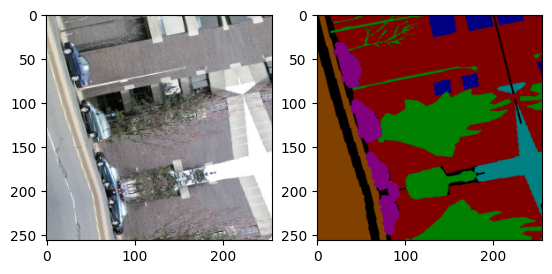

In [ ]:
# In many cases, such as when you're working with grayscale images or when you want to focus on a specific channel of a color image, you might only be interested in one of the channels. In such cases, you can use indexing like [:,:,0] to select that particular channel.
x = image_generator.next()
y = mask_generator.next()

for i in range(0, 1):
    image = x[i]
    mask = y[i]

    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

# Custom Data Generator

In [24]:
!git clone https://github.com/cvjena/labelmefacade.git

Cloning into 'labelmefacade'...
remote: Enumerating objects: 1907, done.
remote: Total 1907 (delta 0), reused 0 (delta 0), pack-reused 1907
Receiving objects: 100% (1907/1907), 102.18 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
# Swap the train and test files
!mv /content/labelmefacade/test.txt /content/labelmefacade/temp.txt
!mv /content/labelmefacade/train.txt /content/labelmefacade/test.txt
!mv /content/labelmefacade/temp.txt /content/labelmefacade/train.txt

In [26]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify

def read_filenames(txt_path):
    with open(txt_path, 'r') as file:
        filenames = [line.strip().replace('images/', '').rsplit('.', 1)[0] for line in file if line.strip()]
    return filenames

def save_patches(patches, directory, base_filename, ext=".png"):
    os.makedirs(directory, exist_ok=True)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j, 0]  # Drop the extra unnecessary dimension
            patch_filename = f"{base_filename}_patch_{i}_{j}{ext}"
            patch_path = os.path.join(directory, patch_filename)
            cv2.imwrite(patch_path, patch)

def patchify_images_and_masks(filenames, root_directory, patch_size, saved_images_path, saved_masks_path):
    image_dir = os.path.join(root_directory, "images")
    mask_dir = os.path.join(root_directory, "labels")

    for filename in filenames:
        image_path = os.path.join(image_dir, f"{filename}.jpg")
        mask_path = os.path.join(mask_dir, f"{filename}.png")

        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Read and resize the image
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            # Ensure the image and mask are the same size
            min_size_x = min(image.shape[1], mask.shape[1])
            min_size_y = min(image.shape[0], mask.shape[0])
            SIZE_X = (min_size_x // patch_size) * patch_size
            SIZE_Y = (min_size_y // patch_size) * patch_size

            # Crop the images to the nearest size divisible by patch_size
            image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)
            mask = Image.fromarray(mask).crop((0, 0, SIZE_X, SIZE_Y))
            mask = np.array(mask)

            # Patchify the images and masks
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
            patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

            # Save the patches
            save_patches(patches_img, saved_images_path, filename)
            save_patches(patches_mask, saved_masks_path, filename)

In [23]:
!rm -rf /content/drive/MyDrive/facade-semantic-seg

In [27]:
out_dir = '/content/drive/MyDrive/facade-semantic-seg'

train_filenames = read_filenames('/content/labelmefacade/train.txt')
test_filenames = read_filenames('/content/labelmefacade/test.txt')

patchify_images_and_masks(train_filenames, '/content/labelmefacade', 256, f'{out_dir}/train/images', f'{out_dir}/train/masks')
patchify_images_and_masks(test_filenames, '/content/labelmefacade', 256, f'{out_dir}/test/images', f'{out_dir}/test/masks')

In [30]:
!ls -1 /content/drive/MyDrive/facade-semantic-seg/train/images | wc -l
!ls -1 /content/drive/MyDrive/facade-semantic-seg/test/images | wc -l
!ls -1 /content/drive/MyDrive/facade-semantic-seg/train/masks | wc -l
!ls -1 /content/drive/MyDrive/facade-semantic-seg/test/masks | wc -l

3408
404
3408
404


In [32]:
DATASET_HOME = '/content/drive/MyDrive/facade-semantic-seg'
DATASET_TRAIN = f'{DATASET_HOME}/train'
DATASET_TEST = f'{DATASET_HOME}/test'

In [33]:
import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical


def rgb_to_labels(rgb_image, class_colors):
    labels_image = np.zeros(rgb_image.shape[:2], dtype=np.uint8)
    for rgb, label in class_colors.items():
        mask = np.all(rgb_image == np.array(rgb), axis=-1)
        labels_image[mask] = label
    return labels_image

# Define the preprocessing function for the generator
def preprocess_mask(mask, n_classes):
    # Convert RGB mask to labels
    labels = rgb_to_labels(mask, class_colors)
    # Convert labels to categorical
    labels_cat = to_categorical(labels, num_classes=n_classes, dtype=np.uint8)
    return labels_cat

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, class_colors, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_colors = class_colors
        self.image_filenames = [image_name for image_name in sorted(os.listdir(image_dir)) if image_name.endswith(".png")] # jpg
        self.mask_filenames = [mask_name for mask_name in sorted(os.listdir(mask_dir)) if mask_name.endswith(".png")]  # png
        self.indexes = np.arange(len(self.image_filenames))
        self.shuffle = shuffle
        self.n_classes = len(class_colors) + 1

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for idx in batch_indexes:
            image_filename = self.image_filenames[idx]
            mask_filename = self.mask_filenames[idx]

            image_path = os.path.join(self.image_dir, image_filename)
            mask_path = os.path.join(self.mask_dir, mask_filename)

            image = cv2.imread(image_path, 1)
            image = Image.fromarray(image)
            image = np.array(image)

            mask = cv2.imread(mask_path, 1)
            mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            mask = Image.fromarray(mask)
            mask = np.array(mask)

            batch_images.append(image)
            batch_masks.append(mask)

        # TODO: Use preprocess_mask function
        labels = np.array([rgb_to_labels(mask, class_colors) for mask in batch_masks])
        batch_masks_cat = to_categorical(labels, num_classes=self.n_classes)

        return np.array(batch_images), np.array(batch_masks_cat)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

# Training

In [38]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Activation
from keras import backend as K

def jaccard_coef(y_true, y_pred):
    """Calculate the Jaccard coefficient, a similarity measure for semantic segmentation."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

def conv2d_block(input_tensor, num_filters, kernel_size=3, batch_norm=True, dropout=0.2):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(num_filters, (kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(num_filters, (kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if dropout > 0:
        x = Dropout(dropout)(x)

    return x

def multi_unet_model(n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # Contraction path
    c1 = conv2d_block(inputs, 16, batch_norm=True, dropout=0.1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv2d_block(p1, 32, batch_norm=True, dropout=0.1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv2d_block(p2, 64, batch_norm=True, dropout=0.2)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv2d_block(p3, 128, batch_norm=True, dropout=0.2)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = conv2d_block(p4, 256, batch_norm=True, dropout=0.3)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, 128, batch_norm=True, dropout=0.2)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, 64, batch_norm=True, dropout=0.2)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, 32, batch_norm=True, dropout=0.1)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, 16, batch_norm=True, dropout=0.1)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs], name='U-Net')

    return model

In [39]:
train_images_path = f'{DATASET_TRAIN}/images'
train_masks_path = f'{DATASET_TRAIN}/masks'
val_images_path = f'{DATASET_TEST}/images'
val_masks_path = f'{DATASET_TEST}/masks'

# Define RGB values for each class
class_colors = {
    (0, 0, 0): 0,        # various
    (128, 0, 0): 1,      # building
    (128, 0, 128): 2,    # car
    (128, 128, 0): 3,    # door
    (128, 128, 128): 4,  # pavement
    (128, 64, 0): 5,     # road
    (0, 128, 128): 6,    # sky
    (0, 128, 0): 7,      # vegetation
    (0, 0, 128): 8       # window
}

batch_size = 8
n_classes = len(class_colors) + 1

train_generator = CustomDataGenerator(image_dir=train_images_path,
                                      mask_dir=train_masks_path,
                                      batch_size=batch_size,
                                      class_colors=class_colors)

train_steps = train_generator.__len__()
print(f'train_steps: {train_steps}')


val_generator = CustomDataGenerator(image_dir=val_images_path,
                                      mask_dir=val_masks_path,
                                      batch_size=batch_size,
                                      class_colors=class_colors)

val_steps = val_generator.__len__()
print(f'val_steps: {val_steps}')

train_steps: 426
val_steps: 50


In [40]:
img, mask = train_generator.__getitem__(0)

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img[0].shape
n_classes = mask.shape[-1]

metrics=['accuracy', jaccard_coef]

print(f'image shape: {img[0].shape}')
print(f'number of classes: {n_classes}')

image shape: (256, 256, 3)
number of classes: 10


In [ ]:
model = multi_unet_model(
        n_classes=n_classes,
        IMG_HEIGHT=IMG_HEIGHT,
        IMG_WIDTH=IMG_WIDTH,
        IMG_CHANNELS=IMG_CHANNELS)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # loss=total_loss
    metrics=metrics)

model.summary()

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    #   callbacks=[mc,es,tb,rl,cv],
                    )

Epoch 1/30
426/426 [==============================] - 170s 351ms/step - loss: 1.5189 - accuracy: 0.5360 - jaccard_coef: 0.1996 - val_loss: 1.2947 - val_accuracy: 0.5968 - val_jaccard_coef: 0.3178
Epoch 2/30
426/426 [==============================] - 119s 278ms/step - loss: 1.1114 - accuracy: 0.6617 - jaccard_coef: 0.3223 - val_loss: 0.9467 - val_accuracy: 0.7060 - val_jaccard_coef: 0.3969
Epoch 3/30
426/426 [==============================] - 119s 280ms/step - loss: 1.0085 - accuracy: 0.6886 - jaccard_coef: 0.3625 - val_loss: 1.0393 - val_accuracy: 0.6886 - val_jaccard_coef: 0.3741
Epoch 4/30
426/426 [==============================] - 118s 277ms/step - loss: 0.9380 - accuracy: 0.7085 - jaccard_coef: 0.3881 - val_loss: 0.7942 - val_accuracy: 0.7411 - val_jaccard_coef: 0.4348
Epoch 5/30
426/426 [==============================] - 118s 277ms/step - loss: 0.8907 - accuracy: 0.7195 - jaccard_coef: 0.4062 - val_loss: 0.7542 - val_accuracy: 0.7623 - val_jaccard_coef: 0.4222
Epoch 6/30
426/426 [

In [ ]:
model.save('my_model.keras')

# Testing

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)


# Using built in keras function for IoU
from keras.metrics import MeanIoU

# n_classes = 9
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 2s 2s/step
Mean IoU = 0.1745909


In [ ]:
import cv2

def read_img(image_path):
    patch_size = 256
    image = cv2.imread(image_path, 1)  #Read each image as BGR
    SIZE_X = (image.shape[1] // patch_size) * patch_size
    SIZE_Y = (image.shape[0] // patch_size) * patch_size
    image = Image.fromarray(image)
    image = image.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
    image = image.resize((SIZE_X, SIZE_Y))  # Try not to resize for semantic segmentation
    return np.array(image)


image_path = '/content/architects-top/all/Mimar Kemalettin/00147.jpg'
image_path = '/content/architects-top/all/Mimar Kemalettin/00113.jpg'
image_path = '/content/architects-top/all/Mimar Kemalettin/00309.jpg'

# Load the image
image = read_img(image_path)

1/1 [==============================] - 2s 2s/step


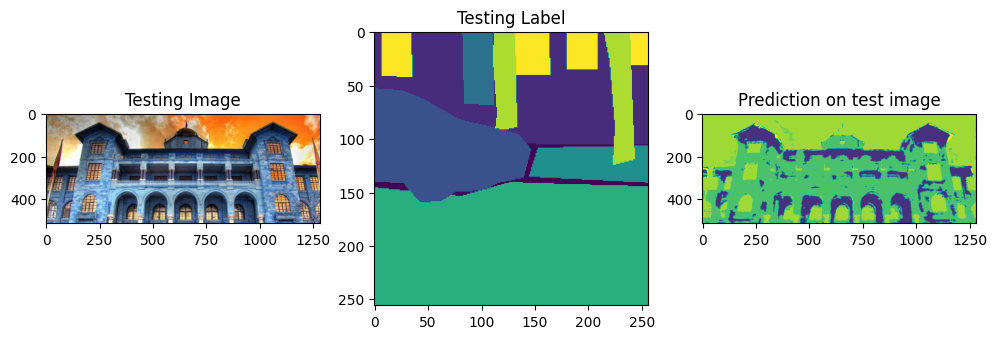

In [ ]:
# Predict on a few images
import random

test_img_number = random.randint(0, len(X_test))
# test_img = X_test[test_img_number]
test_img = image

ground_truth = y_test_argmax[test_img_number]
#test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()